In [31]:
import os 
import glob
from pathlib import Path
from rtmag.paper.parse import parse_tai_string
from sunpy.map import Map
import numpy as np
from skimage.transform import resize
from rtmag.paper.load import load_input_label, MyModel
from rtmag.paper.metric import energy
import matplotlib.pyplot as plt

In [2]:
data_path = "/mnt/f/sdo_AR/NOAA11158_HARP377/hmi"
hmi_p_files = sorted(glob.glob(os.path.join(data_path, '*Bp.fits')))  # x
hmi_t_files = sorted(glob.glob(os.path.join(data_path, '*Bt.fits')))  # y
hmi_r_files = sorted(glob.glob(os.path.join(data_path, '*Br.fits')))  # z
data_paths = list(zip(hmi_p_files, hmi_t_files, hmi_r_files))

In [3]:
ix = 240
data_path = data_paths[ix]
data_path

('/mnt/f/sdo_AR/NOAA11158_HARP377/hmi/hmi.sharp_cea_720s.377.20110214_000000_TAI.Bp.fits',
 '/mnt/f/sdo_AR/NOAA11158_HARP377/hmi/hmi.sharp_cea_720s.377.20110214_000000_TAI.Bt.fits',
 '/mnt/f/sdo_AR/NOAA11158_HARP377/hmi/hmi.sharp_cea_720s.377.20110214_000000_TAI.Br.fits')

In [14]:
hmi_p, hmi_t, hmi_r, = data_path
p_map, t_map, r_map = Map(hmi_p), Map(hmi_t), Map(hmi_r)
maps = [p_map, t_map, r_map]
hmi_data = np.stack([maps[0].data, -maps[1].data, maps[2].data]).transpose()
hmi_data = np.nan_to_num(hmi_data, nan=0.0)
hmi_data = hmi_data.astype(np.float32)

l = 0.36  # Mm
dx = l * 1e8  # cm
dy = l * 1e8  # cm
dz = l * 1e8  # cm

dV = dx * dy * dz  # cm^3

model_input = hmi_data[None, :, :, None, :]
model_input = model_input.transpose(0, 3, 2, 1, 4)
model_input.shape

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


(1, 1, 377, 744, 3)

In [43]:
Path(data_path[0]).name[23:38]

'20110214_000000'

In [44]:
parse_tai_string(Path(data_path[0]).name[23:38])

datetime.datetime(2011, 2, 14, 0, 0)

In [15]:
mm = MyModel("/home/mgjeon/space/workspace/base_important/uno_pi_cc_hnorm_unit_aug/model_75.pt")

Model loaded from epoch 75


In [16]:
b = mm.get_pred_from_numpy(model_input)

Model loaded from epoch 75


In [17]:
dV / 1e23

0.46656000000000003

In [18]:
energy(b, dV) / 1e33

0.2538104328623507

In [45]:
ox, oy, _ = hmi_data.shape
nx, ny = 512, 256

l = 0.36 # Mm

dx = (ox * l)/nx
dy = (oy * l)/ny
dz = dy 

dx, dy, dz = dx * 1e8, dy * 1e8, dz * 1e8  # cm
dV = dx * dy * dz # cm^3
model_input = resize(hmi_data, (nx, ny, 3))
model_input = model_input[None, :, :, None, :]
model_input = model_input.transpose(0, 3, 2, 1, 4)
model_input.shape

(1, 1, 256, 512, 3)

In [48]:
(dx / 1e8) * 512

267.84

In [49]:
0.36 * 744

267.84

In [50]:
(dy / 1e8) * 256

135.72

In [51]:
0.36 * 377

135.72

In [20]:
dV / 1e23

1.4703246784973143

In [21]:
b = mm.get_pred_from_numpy(model_input)

Model loaded from epoch 75


In [22]:
energy(b, dV) / 1e33

0.7668050916486082

In [24]:
hmi_data.shape

(744, 377, 3)

In [30]:
# Define the new shape
L = 378  # Choose your desired value for L
new_shape = (2*L, L)

# Calculate the padding sizes
pad_height = (new_shape[0] - hmi_data.shape[0]) // 2
pad_width = (new_shape[1] - hmi_data.shape[1]) // 2

# Pad the array
padded_arr = np.pad(hmi_data, pad_width=[(pad_height, pad_height), (pad_width, pad_width), (0, 0)], mode='constant', constant_values=0)

# Verify the shape
print(padded_arr.shape)  # Output: (1000, 500)

(756, 377, 3)


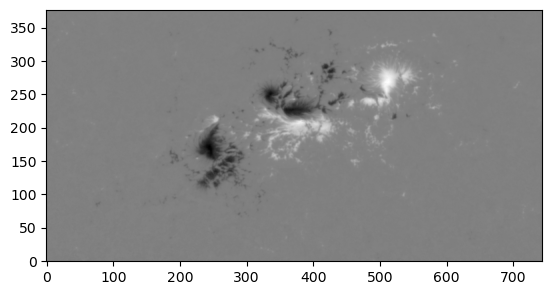

In [34]:
plt.imshow(hmi_data[:, :, 2].T, origin='lower', cmap='gray')

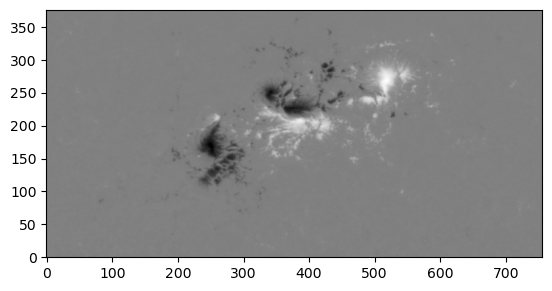

In [32]:
plt.imshow(padded_arr[:, :, 2].T, origin='lower', cmap='gray')

In [35]:
l = 0.36  # Mm
dx = l * 1e8  # cm
dy = l * 1e8  # cm
dz = l * 1e8  # cm

dV = dx * dy * dz  # cm^3

model_input = padded_arr[None, :, :, None, :]
model_input = model_input.transpose(0, 3, 2, 1, 4)
model_input.shape

(1, 1, 377, 756, 3)

In [36]:
b = mm.get_pred_from_numpy(model_input)

Model loaded from epoch 75


In [38]:
b.shape

(756, 377, 256, 3)

In [37]:
energy(b, dV) / 1e33

0.25393156469092554